# HCL's Probabilistic Identity Matching

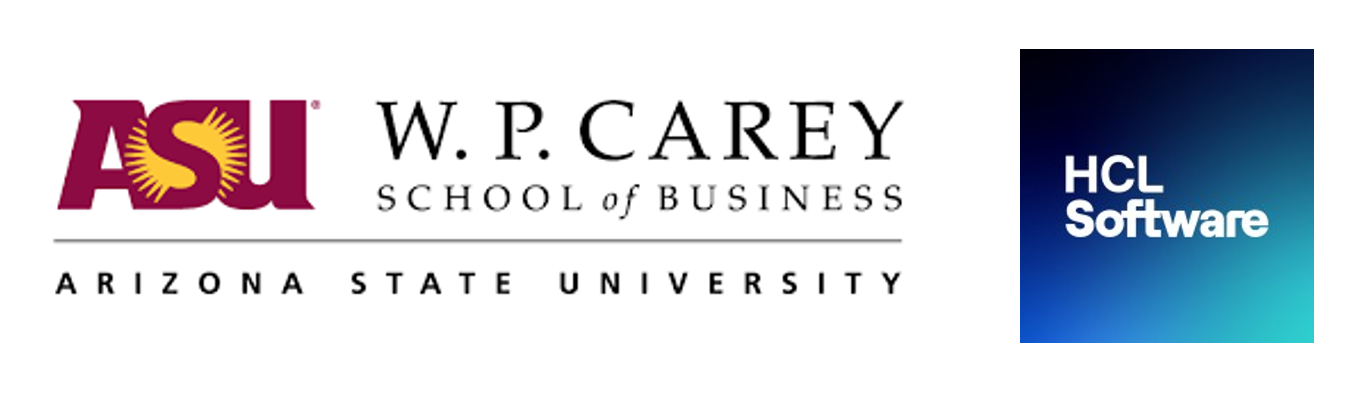
#### Problem Statement:
>Today’s digital companies have many touchpoints with their customers across many mediums and siloed branches of business. These scenarios typically result in isolated profiles/accounts residing in different systems of record and entirely separate lines of business. In order to build “unified identities” which combine these profiles from across these channels, intelligent “stitching” of these profiles must be completed that is reliable and tolerant to placeholder or default data which can cause runaway effects. <br>
Many profiles being loosely coupled through implicit or explicit matching into a single identity would be a tell-tale sign of a runaway condition. <br>

#### Goal
>The goal of this project is to create a probabilistic approach to stitch profiles together into a reasonably reliable unified identity. The approach should be able to use partial and close matching to create relationships between profiles within a specific % of certainty and be able to dynamically diagnose and avoid problematic matching that can lead to a runaway behavior. <br>


### Import Libraries

In [1]:
# !pip install spacy
# !pip install fuzzywuzzy
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy

from tqdm import tqdm
from thefuzz import fuzz, process

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
nlp=spacy.load('en_core_web_sm')

## Relevant Functions
### CleanMyDataFrame
- This functions helps in preprocessing the dataframe containing information from various sources. 
- It standardizes the different attributes which will be used for Identity Matching like name,phone,email, and address.

In [3]:
# Define Function to clean the dataset
def CleanMyDataFrame(df1):
    
    df=df1.copy(deep=True)
    df.fillna(' ',inplace=True)
    
    #Phone Number Cleaning
    df['phone']=df['phone'].str.replace(r'[^\w]', '')
    df['phone']=df['phone'].str.strip().str[-10:]
    df['phone'].replace('0000000000',"",inplace=True)
    
    #Name Cleaning
    df['name']=df['name'].str.replace(r'[.,]','').str.lower()
    
    #Email Cleaning
    df=pd.concat([df,df['email'].str.split('@',expand=True)],axis=1)
    df.rename(columns={0:'email_id',1:'email_domain'},inplace=True)
    df['email'].replace('default@gmail.com',"",inplace=True)
    
    #Address Cleaning
        # Remove .,
    address=df['address']
    myaddress=address.str.replace(r'[.,]','').str.lower()

        # Avenue Cleaning (av,ave,avenue)
    myaddress=[myaddress.replace('av','avenue') for myaddress in myaddress]
    myaddress=[myaddress.replace('avenueenue','avenue') for myaddress in myaddress]
    myaddress=[myaddress.replace('avenuee','avenue') for myaddress in myaddress]

        # Street Cleaning (St)
    myaddress=[myaddress.replace('street','st') for myaddress in myaddress]

        # Road Cleaning (Rd)
    myaddress=[myaddress.replace('road','rd') for myaddress in myaddress]
    df['address']=myaddress
    
    return df

## Document Based Matching 
- The document based matching involves creating a document containing all attribues associated with an entry. With this documents we create a TFIDF matrix and compute similarity scores between each entry. 
- We also define a threshold, which is used to filter out relevant matches.

In [4]:
# Built a function to process the cosine similarity and provide output
# Threshold = 30% MATCH

def Document_Matching(df1,threshold=0.30):
    
    df=df1.copy(deep=True)
    #Clean Data
    Preprocessed_data=CleanMyDataFrame(df)
    
    #Replace NaN with ' '
    Preprocessed_data.fillna(' ',inplace=True)
    
    #Create Document Matrix
    Preprocessed_data['doc']=Preprocessed_data[["name","phone","email","address","city"]].apply(' '.join,axis=1)
    Preprocessed_data.drop(['name','phone','email','address','city','email_id','email_domain'],axis=1,inplace=True)
    
    #Create Term-Frequency Inverse Document Frequency Matrix for Document col
    my_tfidf=TfidfVectorizer(analyzer="char",ngram_range=(1,3))
    documentmatrix=my_tfidf.fit_transform(Preprocessed_data['doc'])
    
    documentmatrix=pd.DataFrame(documentmatrix.toarray(),columns=my_tfidf.get_feature_names_out())
    print('Similarity Scores Generated')
    score=cosine_similarity(documentmatrix)
    
    #Extract based on Threshold
    documentmatrix['Match']=str('No Match')
    documentmatrix['score']=str('No score')
    for j in tqdm(range(0,len(score))):
        if max(score[j])>threshold:
            documentmatrix['Match'][j]=[i for i,e in enumerate(score[j]) if e>threshold]
            documentmatrix['score'][j]=[round(e,2) for i,e in enumerate(score[j]) if e>threshold]
    
    #Add Similarity Column
    df['Document_Match']=documentmatrix['Match']
    df['Document_Score']=documentmatrix['score']
    
    return df

## Attribute Based Matching
- The attribute based matching uses each attribute independently to obtain similarity scores.
- The final score is calculated through weighted-sum between scores (names scores, phones scores, email scores & address scores) obtained through independent attribute comparisons.
- An internal threshold and external threshold is used in this method.

In [5]:
def Wt_Attribute_Matching(df1,attribute=['name',"phone","email","address"],threshold=0.90):
    
    df=df1.copy(deep=True)
    # Set Internal Threshold
    int_threshold={'name':0.8,'phone':1,'address':0.7,'email':1}
#     int_threshold={'name':0.8,'phone':1,'address':0.7,'email':1}
    
    # Final score weights
    wt_dict={'name':0.5,'phone':1,'address':0.5,'email':1}
#     wt_dict={'name':0.5,'phone':1,'address':0.5,'email':0.85}
    
    #Clean Data
    Preprocessed_data=CleanMyDataFrame(df)
    
    #Replace NaN with ' '
    Preprocessed_data.fillna(' ',inplace=True)
    
    #Weighted Score
    for i,att in enumerate(attribute):
        my_tfidf=TfidfVectorizer()
        documentmatrix=my_tfidf.fit_transform(Preprocessed_data[att])
        documentmatrix=pd.DataFrame(documentmatrix.toarray(),columns=my_tfidf.get_feature_names_out())
        
        # Nullify similarity less than required internal threshold
        csim=cosine_similarity(documentmatrix)
        csim[csim<int_threshold[att]]=0
        print('For attribute: ',att)
        if i==0:
            score=wt_dict[att]*csim
        else:
            score=score+wt_dict[att]*csim
    
    #Extract based on Threshold
    documentmatrix['Match']=str('No Match')
    documentmatrix['score']=str('No score')
    for j in tqdm(range(0,len(score))):
        if max(score[j])>threshold:
            documentmatrix['Match'][j]=[i for i,e in enumerate(score[j]) if e>threshold]
            documentmatrix['score'][j]=[round(e,2) for i,e in enumerate(score[j]) if e>threshold]
    
    #Add Similarity Column
    df['Wt_Attribute_Match']=documentmatrix['Match']
    df['Wt_Attribute_Score']=documentmatrix['score']
    
    return df

# Test Use Case
### Import Data
- Considering 3 sources of data, each representing differently formatted datasets
- Join these datasets to obtain a single data source

In [6]:
data1=pd.read_csv('asu-project-sample-data.csv')
data2=pd.read_csv('asu-data-defaultvalues.csv')
data3=pd.read_csv('asu-data-namephoneformatting.csv')

data3.phone = data3.phone.astype(str)
master=data1.append([data2,data3])

master.reset_index(drop =True,inplace=True)
master.head()

refId-ignore    uid              name  \
0  46B84838-CCF6-7DC8-99E4-9EBC6ECE5571  base1  Keefe O. Dillard   
1  421A4A43-A4F1-10A2-FE4D-4CFCABEC633F  base2  Hayden R. Bailey   
2  E2ABD85E-259F-DDFA-4CAD-998D4583D311  base3   Clarke, Iona Y.   
3  19EEBA18-A167-B9A1-488E-0C76610CCBE2  base4    Lani V. Rivera   
4  E3BACBA4-AAD1-9F86-BAA0-01123B8F9C1B  base5  Kelley, Faith N.   

            phone                         email  \
0  1-683-517-3336               nulla@google.ca   
1  (637) 780-5192  ligula.aliquam.erat@yahoo.ca   
2  (867) 918-3850               vel@hotmail.com   
3  1-339-629-1690          sed.pharetra@aol.edu   
4  (736) 732-4193  rhoncus.proin@protonmail.net   

                         address            city  
0               965-1520 Nec Av.           Dover  
1     Ap #901-5557 Fringilla St.       Frankfort  
2     Ap #668-110 Nonummy Street       Davenport  
3  P.O. Box 747, 3351 Dictum St.        Savannah  
4          Ap #814-7811 Nec, Rd.  Salt Lake City

### CleanMyData Function Example:
- Names are lowercased, removal of "." & ","
- Phone numbers are strictly formatted to 10 digit, removing "(",")","-" & "+1"
- Email have their username & domain split
- Address with no "." & "," <br>
    - Common terms like Av,Ave,Av. replace with avenue. <br>
    - Common terms like street & St. replace with st <br>
    - Common terms like road replace with rd

In [7]:
Clean_Data=CleanMyDataFrame(master)
Clean_Data.head()

refId-ignore    uid             name       phone  \
0  46B84838-CCF6-7DC8-99E4-9EBC6ECE5571  base1  keefe o dillard  6835173336   
1  421A4A43-A4F1-10A2-FE4D-4CFCABEC633F  base2  hayden r bailey  6377805192   
2  E2ABD85E-259F-DDFA-4CAD-998D4583D311  base3    clarke iona y  8679183850   
3  19EEBA18-A167-B9A1-488E-0C76610CCBE2  base4    lani v rivera  3396291690   
4  E3BACBA4-AAD1-9F86-BAA0-01123B8F9C1B  base5   kelley faith n  7367324193   

                          email                    address            city  \
0               nulla@google.ca        965-1520 nec avenue           Dover   
1  ligula.aliquam.erat@yahoo.ca  ap #901-5557 fringilla st       Frankfort   
2               vel@hotmail.com     ap #668-110 nonummy st       Davenport   
3          sed.pharetra@aol.edu  po box 747 3351 dictum st        Savannah   
4  rhoncus.proin@protonmail.net        ap #814-7811 nec rd  Salt Lake City   

              email_id    email_domain  
0                nulla       google.ca  
1  ligula.aliquam.erat        yahoo.ca  
2                  vel     hotmail.com  
3         sed.pharetra         aol.edu  
4        rhoncus.proin  protonmail.net

#### Document Based Matching

In [8]:
Document_Matching_Results=Document_Matching(master)

Similarity Scores Generated


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:46<00:00, 10.48it/s]


In [9]:
Document_Matching_Results.sort_values('refId-ignore')

refId-ignore            uid  \
1526  003D827A-9526-6064-4D8B-9D38D6B69BFE       base1527   
2526  003D827A-9526-6064-4D8B-9D38D6B69BFE   formatting27   
2026  003D827A-9526-6064-4D8B-9D38D6B69BFE     defaults27   
504   003EAAA1-076C-0487-B87E-5175B97E5EA7        base505   
740   00644B3F-ABF2-F4CF-48BA-426ADAA89542        base741   
987   015CDDDC-F066-E2BD-CD98-6485095FA596        base988   
1482  0169383E-B50D-7628-CCC7-A956422FCB02       base1483   
1928  0198538D-C331-B6EB-28D4-81FCE917AFA9       base1929   
2928  0198538D-C331-B6EB-28D4-81FCE917AFA9  formatting429   
2428  0198538D-C331-B6EB-28D4-81FCE917AFA9    defaults429   
1396  025EC940-1ADE-7DA9-1C3D-8F798C678EBC       base1397   
656   027DC448-CB3F-4E88-25C6-5B65C152FCFE        base657   
905   02912E29-E1D9-4866-4B95-CC8B939CAB9B        base906   
1138  02B29142-C743-1083-1C13-CBB7192685DA       base1139   
1344  02D87F59-A6DC-46E1-E849-ED113A0B7A6D       base1345   
693   030E378F-9C9B-C731-BB8D-C23BC457C393        base694   
1085  031BE968-D1A9-E240-4683-EFC38FE677CA       base1086   
1790  0388A4B1-A46F-E2A1-7EE4-32943CB13765       base1791   
2790  0388A4B1-A46F-E2A1-7EE4-32943CB13765  formatting291   
2290  0388A4B1-A46F-E2A1-7EE4-32943CB13765    defaults291   
101   03914423-6A87-63C6-3795-455D1D5DCC57        base102   
1463  03A7840F-697F-45A4-DBAB-8140CB7C6124       base1464   
1554  03ACD71B-BE31-5989-1397-F878BF043CD0       base1555   
2554  03ACD71B-BE31-5989-1397-F878BF043CD0   formatting55   
2054  03ACD71B-BE31-5989-1397-F878BF043CD0     defaults55   
1151  03E5D59E-9A35-5608-CA14-81A6A170BE8E       base1152   
433   041BE162-DCED-A221-A003-5CE2226011E8        base434   
2328  0443B3BC-8E61-0169-4398-ED9F6A925235    defaults329   
1828  0443B3BC-8E61-0169-4398-ED9F6A925235       base1829   
2828  0443B3BC-8E61-0169-4398-ED9F6A925235  formatting329   
1947  04B5D197-9276-BF90-2DCF-C67B61236785       base1948   
2447  04B5D197-9276-BF90-2DCF-C67B61236785    defaults448   
2947  04B5D197-9276-BF90-2DCF-C67B61236785  formatting448   
1390  04F9874E-33CA-C777-5E90-31B4DDD326EE       base1391   
2050  05172DA0-5806-1BBC-2BEC-4651485D453C     defaults51   
2550  05172DA0-5806-1BBC-2BEC-4651485D453C   formatting51   
1550  05172DA0-5806-1BBC-2BEC-4651485D453C       base1551   
2926  05681293-E8D6-4EBE-04B2-FCDA5EE25EB4  formatting427   
1926  05681293-E8D6-4EBE-04B2-FCDA5EE25EB4       base1927   
2426  05681293-E8D6-4EBE-04B2-FCDA5EE25EB4    defaults427   
1120  057C68D5-AB2B-121A-EE9A-A67BC06005C0       base1121   
673   0635E7E6-E30A-EDE9-9754-3063B903E6A6        base674   
1886  066A98CE-C193-967F-BCB4-2B4E4AAF943F       base1887   
2386  066A98CE-C193-967F-BCB4-2B4E4AAF943F    defaults387   
2886  066A98CE-C193-967F-BCB4-2B4E4AAF943F  formatting387   
380   067423E0-9368-DF11-2058-575B82E1F402        base381   
1363  068D33A5-979C-2C5D-A28C-7444C0BA84D2       base1364   
1746  0703623C-EA8F-1CB5-281A-D6CD15CB3E6D       base1747   
2246  0703623C-EA8F-1CB5-281A-D6CD15CB3E6D    defaults247   
2746  0703623C-EA8F-1CB5-281A-D6CD15CB3E6D  formatting247   
1101  075A7A3A-BAB8-231A-4974-4BA796D1559C       base1102   
2137  0858CCCE-56D0-3239-529A-18B9988B225D    defaults138   
2637  0858CCCE-56D0-3239-529A-18B9988B225D  formatting138   
1637  0858CCCE-56D0-3239-529A-18B9988B225D       base1638   
1862  0867489C-7F9B-C796-549C-34BDB2BBB81A       base1863   
2862  0867489C-7F9B-C796-549C-34BDB2BBB81A  formatting363   
2362  0867489C-7F9B-C796-549C-34BDB2BBB81A    defaults363   
971   08733CC7-D5DC-7CCB-E782-D4742EC99CD1        base972   
1662  08C9D631-A789-47C2-91E2-35B1E1E2B8D8       base1663   
2162  08C9D631-A789-47C2-91E2-35B1E1E2B8D8    defaults163   
2662  08C9D631-A789-47C2-91E2-35B1E1E2B8D8  formatting163   
675   093454E4-9EDD-68FB-61D3-0A7492493E1D        base676   
1334  097E8832-D997-27C4-5D1F-569BE8ED97DD       base1335   
741   0996DA5F-79A3-8113-5B88-71AF232E358D        base742   
184   09984F1D-A579-A323-59E3-3566BB8C7334        base185   
1112

#### Attribute Based Matching

In [10]:
Wt_Attribute_Matching_Results=Wt_Attribute_Matching(master)

For attribute:  name
For attribute:  phone
For attribute:  email
For attribute:  address


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:17<00:00, 11.63it/s]


In [11]:
Wt_Attribute_Matching_Results.sort_values('refId-ignore')

refId-ignore            uid  \
1526  003D827A-9526-6064-4D8B-9D38D6B69BFE       base1527   
2526  003D827A-9526-6064-4D8B-9D38D6B69BFE   formatting27   
2026  003D827A-9526-6064-4D8B-9D38D6B69BFE     defaults27   
504   003EAAA1-076C-0487-B87E-5175B97E5EA7        base505   
740   00644B3F-ABF2-F4CF-48BA-426ADAA89542        base741   
987   015CDDDC-F066-E2BD-CD98-6485095FA596        base988   
1482  0169383E-B50D-7628-CCC7-A956422FCB02       base1483   
1928  0198538D-C331-B6EB-28D4-81FCE917AFA9       base1929   
2928  0198538D-C331-B6EB-28D4-81FCE917AFA9  formatting429   
2428  0198538D-C331-B6EB-28D4-81FCE917AFA9    defaults429   
1396  025EC940-1ADE-7DA9-1C3D-8F798C678EBC       base1397   
656   027DC448-CB3F-4E88-25C6-5B65C152FCFE        base657   
905   02912E29-E1D9-4866-4B95-CC8B939CAB9B        base906   
1138  02B29142-C743-1083-1C13-CBB7192685DA       base1139   
1344  02D87F59-A6DC-46E1-E849-ED113A0B7A6D       base1345   
693   030E378F-9C9B-C731-BB8D-C23BC457C393        base694   
1085  031BE968-D1A9-E240-4683-EFC38FE677CA       base1086   
1790  0388A4B1-A46F-E2A1-7EE4-32943CB13765       base1791   
2790  0388A4B1-A46F-E2A1-7EE4-32943CB13765  formatting291   
2290  0388A4B1-A46F-E2A1-7EE4-32943CB13765    defaults291   
101   03914423-6A87-63C6-3795-455D1D5DCC57        base102   
1463  03A7840F-697F-45A4-DBAB-8140CB7C6124       base1464   
1554  03ACD71B-BE31-5989-1397-F878BF043CD0       base1555   
2554  03ACD71B-BE31-5989-1397-F878BF043CD0   formatting55   
2054  03ACD71B-BE31-5989-1397-F878BF043CD0     defaults55   
1151  03E5D59E-9A35-5608-CA14-81A6A170BE8E       base1152   
433   041BE162-DCED-A221-A003-5CE2226011E8        base434   
2328  0443B3BC-8E61-0169-4398-ED9F6A925235    defaults329   
1828  0443B3BC-8E61-0169-4398-ED9F6A925235       base1829   
2828  0443B3BC-8E61-0169-4398-ED9F6A925235  formatting329   
1947  04B5D197-9276-BF90-2DCF-C67B61236785       base1948   
2447  04B5D197-9276-BF90-2DCF-C67B61236785    defaults448   
2947  04B5D197-9276-BF90-2DCF-C67B61236785  formatting448   
1390  04F9874E-33CA-C777-5E90-31B4DDD326EE       base1391   
2050  05172DA0-5806-1BBC-2BEC-4651485D453C     defaults51   
2550  05172DA0-5806-1BBC-2BEC-4651485D453C   formatting51   
1550  05172DA0-5806-1BBC-2BEC-4651485D453C       base1551   
2926  05681293-E8D6-4EBE-04B2-FCDA5EE25EB4  formatting427   
1926  05681293-E8D6-4EBE-04B2-FCDA5EE25EB4       base1927   
2426  05681293-E8D6-4EBE-04B2-FCDA5EE25EB4    defaults427   
1120  057C68D5-AB2B-121A-EE9A-A67BC06005C0       base1121   
673   0635E7E6-E30A-EDE9-9754-3063B903E6A6        base674   
1886  066A98CE-C193-967F-BCB4-2B4E4AAF943F       base1887   
2386  066A98CE-C193-967F-BCB4-2B4E4AAF943F    defaults387   
2886  066A98CE-C193-967F-BCB4-2B4E4AAF943F  formatting387   
380   067423E0-9368-DF11-2058-575B82E1F402        base381   
1363  068D33A5-979C-2C5D-A28C-7444C0BA84D2       base1364   
1746  0703623C-EA8F-1CB5-281A-D6CD15CB3E6D       base1747   
2246  0703623C-EA8F-1CB5-281A-D6CD15CB3E6D    defaults247   
2746  0703623C-EA8F-1CB5-281A-D6CD15CB3E6D  formatting247   
1101  075A7A3A-BAB8-231A-4974-4BA796D1559C       base1102   
2137  0858CCCE-56D0-3239-529A-18B9988B225D    defaults138   
2637  0858CCCE-56D0-3239-529A-18B9988B225D  formatting138   
1637  0858CCCE-56D0-3239-529A-18B9988B225D       base1638   
1862  0867489C-7F9B-C796-549C-34BDB2BBB81A       base1863   
2862  0867489C-7F9B-C796-549C-34BDB2BBB81A  formatting363   
2362  0867489C-7F9B-C796-549C-34BDB2BBB81A    defaults363   
971   08733CC7-D5DC-7CCB-E782-D4742EC99CD1        base972   
1662  08C9D631-A789-47C2-91E2-35B1E1E2B8D8       base1663   
2162  08C9D631-A789-47C2-91E2-35B1E1E2B8D8    defaults163   
2662  08C9D631-A789-47C2-91E2-35B1E1E2B8D8  formatting163   
675   093454E4-9EDD-68FB-61D3-0A7492493E1D        base676   
1334  097E8832-D997-27C4-5D1F-569BE8ED97DD       base1335   
741   0996DA5F-79A3-8113-5B88-71AF232E358D        base742   
184   09984F1D-A579-A323-59E3-3566BB8C7334        base185   
1112

In [12]:
Document_Matching_Results["Document_Match"]=Document_Matching_Results["Document_Match"].map(str)
Wt_Attribute_Matching_Results["Wt_Attribute_Match"]=Wt_Attribute_Matching_Results["Wt_Attribute_Match"].map(str)

print("No. of entries: ",len(Clean_Data['refId-ignore']),"\n")
print("No. of Identities original: ",len(pd.unique(Clean_Data['refId-ignore'])),"\n")
print("No. of Identities predicted by TFIDF Document Matching: ",len(pd.unique(Document_Matching_Results['Document_Match'])),"\n")
print("No. of Identities predicted by TFIDF Attribute Matching: ",len(pd.unique(Wt_Attribute_Matching_Results['Wt_Attribute_Match'])))

No. of entries:  3000 

No. of Identities original:  2000 

No. of Identities predicted by TFIDF Document Matching:  2885 

No. of Identities predicted by TFIDF Attribute Matching:  2115


> Incorrect IDs were **1000** (3000-2000) <br>
> Document Matching predicted **2885** identities (Improvement of of **11.5%**) <br>
> Attribute Matching predicted **2115** identities (Improvement of **88.5%**) <br>

#### Export dataset in excel for Data Validation

In [13]:
Wt_Attribute_Matching_Results["Wt_Attribute_Match"] = Wt_Attribute_Matching_Results["Wt_Attribute_Match"].astype('category')
Wt_Attribute_Matching_Results['id']=Wt_Attribute_Matching_Results["Wt_Attribute_Match"].cat.codes

Wt_Attribute_Matching_Results.to_csv('Matching.csv',index=False)